In [ ]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

from datasets import Dataset 
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback
import torch

from data_utils import DataUtils

In [2]:
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
DS_SPLIT = 0.2
MIN_SPECIALITY_THRESHOLD = 100
DATASET_PATH = 'data/mtsamples.csv'
MODEL_NAME = 'distilbert-base-uncased'

In [3]:
df = pd.read_csv(DATASET_PATH, usecols=['medical_specialty', 'transcription'])
df.head()

,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...


In [4]:
utils = DataUtils()
df = utils.handle_nulls(df)
df = utils.handle_duplicates(df)

df['text'] = df['transcription'].map(utils.clean_text)
df['medical_specialty'] = df['medical_specialty'].str.strip()

===== Null Summary =====
medical_specialty     0
transcription        33
dtype: int64
Dropping rows with missing values...
===== Duplicate Summary =====
Count: 2
Dropping duplicate rows...


===== Class Distribution =====
medical_specialty
Surgery                          1088
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Discharge Summary                 108
Name: count, dtype: int64


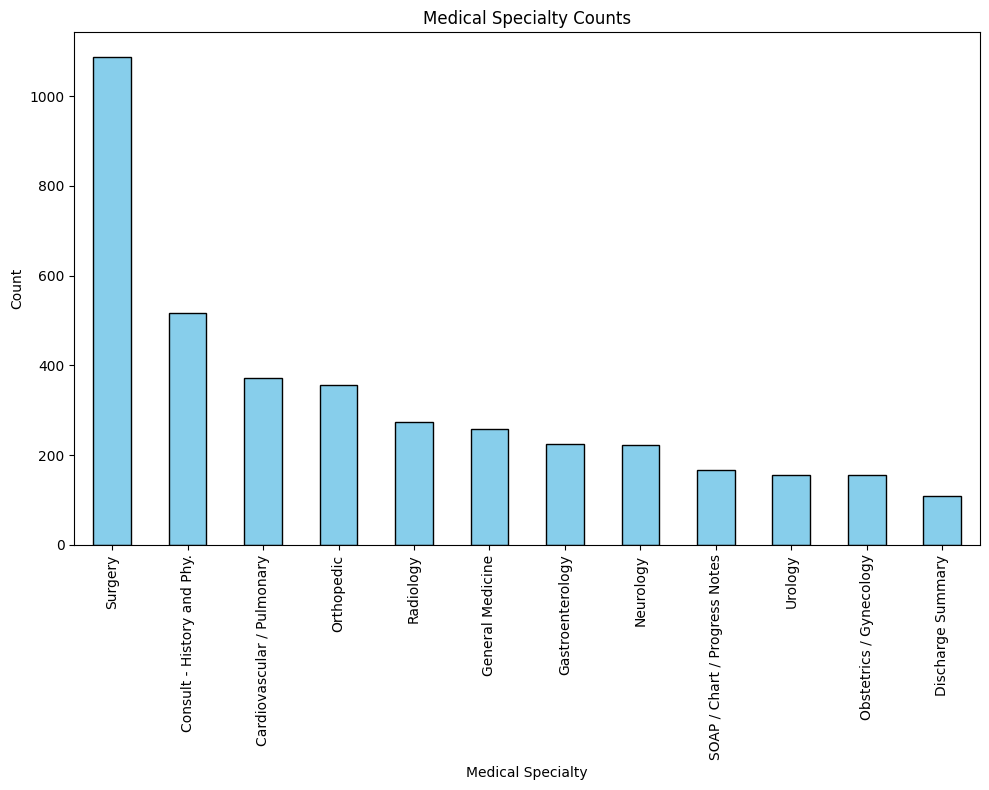

In [5]:
speciality_count = utils.class_distribution(df.medical_specialty, verbose=False)
df = df[df.medical_specialty.isin(speciality_count[speciality_count >= MIN_SPECIALITY_THRESHOLD].index)]
_ = utils.class_distribution(df.medical_specialty, 'Medical Specialty', show_plot=True)

In [6]:
df['label'], uniques = pd.factorize(df["medical_specialty"])
print("Unique medical specialties:")
for i, label in enumerate(uniques):
    print(f"{i}: {label}")

df.sample(5, random_state=42)

Unique medical specialties:
0: Cardiovascular / Pulmonary
1: Neurology
2: Urology
3: General Medicine
4: Surgery
5: SOAP / Chart / Progress Notes
6: Radiology
7: Orthopedic
8: Obstetrics / Gynecology
9: Gastroenterology
10: Discharge Summary
11: Consult - History and Phy.


,medical_specialty,transcription,text,label
2950,Neurology,The patient states that she has been doing fai...,the patient states that she has been doing fai...,1
2877,Neurology,"PREOPERATIVE DIAGNOSIS: , Right temporal lobe ...",preoperative diagnosis right temporal lobe int...,1
4179,Consult - History and Phy.,"REASON FOR CONSULTATION:, Pneumothorax and su...",reason for consultation pneumothorax and subcu...,11
2207,Orthopedic,"PREOPERATIVE DIAGNOSIS:, Foreign body, right ...",preoperative diagnosis foreign body right foot...,7
331,Surgery,"PREOPERATIVE DIAGNOSIS: , Severe scoliosis.,AN...",preoperative diagnosis severe scoliosis. anest...,4


In [7]:
ros = RandomOverSampler(random_state=42)
df_resampled, y_resampled = ros.fit_resample(
    df[['text']],
    df['label']
)
df_resampled['label'] = y_resampled
print(f"Resampled Shape: {df_resampled.shape}")

Resampled Shape: (13056, 2)


In [8]:
train_df, test_df = train_test_split(df_resampled, test_size=DS_SPLIT, stratify=df_resampled['label'], random_state=42)
print(f"Train Shape: {train_df.shape}, Test Shape: {test_df.shape}")

Train Shape: (10444, 2), Test Shape: (2612, 2)


In [9]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True, max_length=MAX_SEQ_LEN)

train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

c:\Users\Mahfuzur\.conda\envs\torch-gpu\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/10444 [00:00<?, ? examples/s]

Map:   0%|          | 0/2612 [00:00<?, ? examples/s]

In [10]:
label2id = {label: idx for idx, label in enumerate(uniques)}
id2label = {idx: label for idx, label in enumerate(uniques)}

model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(uniques),
    id2label=id2label,
    label2id=label2id,
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

In [12]:
training_args = TrainingArguments(
    output_dir="./results",         
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    learning_rate=2e-5,             
    per_device_train_batch_size=BATCH_SIZE, 
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,             
    weight_decay=0.01,
    report_to="none",
    logging_dir=None,           
    logging_steps=-1
)

trainer = Trainer(
    model=model,       
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

  0%|          | 0/6530 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 1.0031133890151978, 'eval_accuracy': 0.6316998468606432, 'eval_f1_weighted': 0.6117151883754803, 'eval_runtime': 10.4154, 'eval_samples_per_second': 250.783, 'eval_steps_per_second': 15.746, 'epoch': 1.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.8409560322761536, 'eval_accuracy': 0.6772588055130169, 'eval_f1_weighted': 0.6640028899495475, 'eval_runtime': 11.7255, 'eval_samples_per_second': 222.762, 'eval_steps_per_second': 13.987, 'epoch': 2.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.7789987921714783, 'eval_accuracy': 0.6673047473200613, 'eval_f1_weighted': 0.6455677798060689, 'eval_runtime': 11.1657, 'eval_samples_per_second': 233.93, 'eval_steps_per_second': 14.688, 'epoch': 3.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.7321803569793701, 'eval_accuracy': 0.6944869831546707, 'eval_f1_weighted': 0.6709105476455723, 'eval_runtime': 11.2275, 'eval_samples_per_second': 232.642, 'eval_steps_per_second': 14.607, 'epoch': 4.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.7120484709739685, 'eval_accuracy': 0.6914241960183767, 'eval_f1_weighted': 0.6673895590503287, 'eval_runtime': 11.5991, 'eval_samples_per_second': 225.19, 'eval_steps_per_second': 14.139, 'epoch': 5.0}


  0%|          | 0/164 [00:00<?, ?it/s]

{'eval_loss': 0.70377516746521, 'eval_accuracy': 0.6875957120980092, 'eval_f1_weighted': 0.6677173599674945, 'eval_runtime': 10.4907, 'eval_samples_per_second': 248.983, 'eval_steps_per_second': 15.633, 'epoch': 6.0}
{'train_runtime': 847.952, 'train_samples_per_second': 123.167, 'train_steps_per_second': 7.701, 'train_loss': 0.8419572052266782, 'epoch': 6.0}


TrainOutput(global_step=3918, training_loss=0.8419572052266782, metrics={'train_runtime': 847.952, 'train_samples_per_second': 123.167, 'train_steps_per_second': 7.701, 'total_flos': 4151208711831552.0, 'train_loss': 0.8419572052266782, 'epoch': 6.0})

In [13]:
eval_results = trainer.evaluate()
print(f"Evaluation results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

  0%|          | 0/164 [00:00<?, ?it/s]

Evaluation results:
eval_loss: 0.7322
eval_accuracy: 0.6945
eval_f1_weighted: 0.6709
eval_runtime: 10.7868
eval_samples_per_second: 242.1470
eval_steps_per_second: 15.2040
epoch: 6.0000


  0%|          | 0/164 [00:00<?, ?it/s]

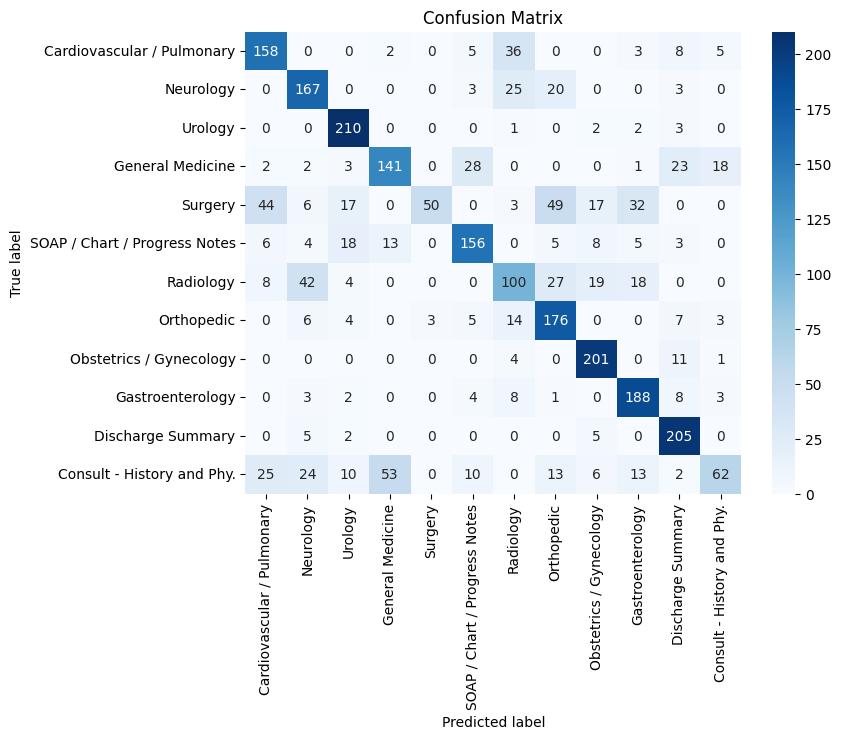

In [ ]:
predictions = trainer.predict(test_ds)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

classes = list(id2label.values())
cm = confusion_matrix(y_true, y_pred)
utils.plot_confusion_matrix(cm, classes)

In [15]:
def classify(text):
    tokens = tokenizer.encode(text, return_tensors='pt', truncation=True, padding=True, max_length=MAX_SEQ_LEN)
    tokens = tokens.to(model.device)
    result = model(tokens)
    return int(torch.argmax(result.logits))

samples = pd.DataFrame()
for i in range(5):
    sample = test_df[test_df.label == i].sample(1, random_state=21)
    samples = pd.concat([samples, sample])

samples = samples.reset_index(drop=True)
samples = samples.rename(columns={'label': 'true_label'})
samples['predicted_label'] = samples['text'].apply(classify)
samples

,text,true_label,predicted_label
0,history of present illness this is a year old ...,0,0
1,interpretation mri of the cervical spine witho...,1,1
2,preoperative diagnosis right inguinal hernia. ...,2,2
3,subjective this year old man presents to the e...,3,3
4,procedures performed phenol neurolysis left mu...,4,1
